*Importing essential libraries*

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [24]:
import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91954\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

*Loading the dataset*

In [25]:
data = pd.read_csv('spam-text-messages.csv')
df = pd.read_csv('spam-text-messages.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
spam_messages = df[df['Category'] == 'spam']['Message']
spam_messages

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: Message, Length: 747, dtype: object

In [27]:
with open('spam_messages.txt', 'w', encoding='utf-8') as file:
    for message in spam_messages:
        file.write(message + '\n')

#### **Exploratory Data Analysis(EDA)**
 * Given performing some operations like shape,head,tail,info,describe etc.

In [29]:
print(data.shape)

(5572, 2)


In [7]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

Let us start by checking the number of spam and ham messages we have in our dataset

In [8]:
data['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

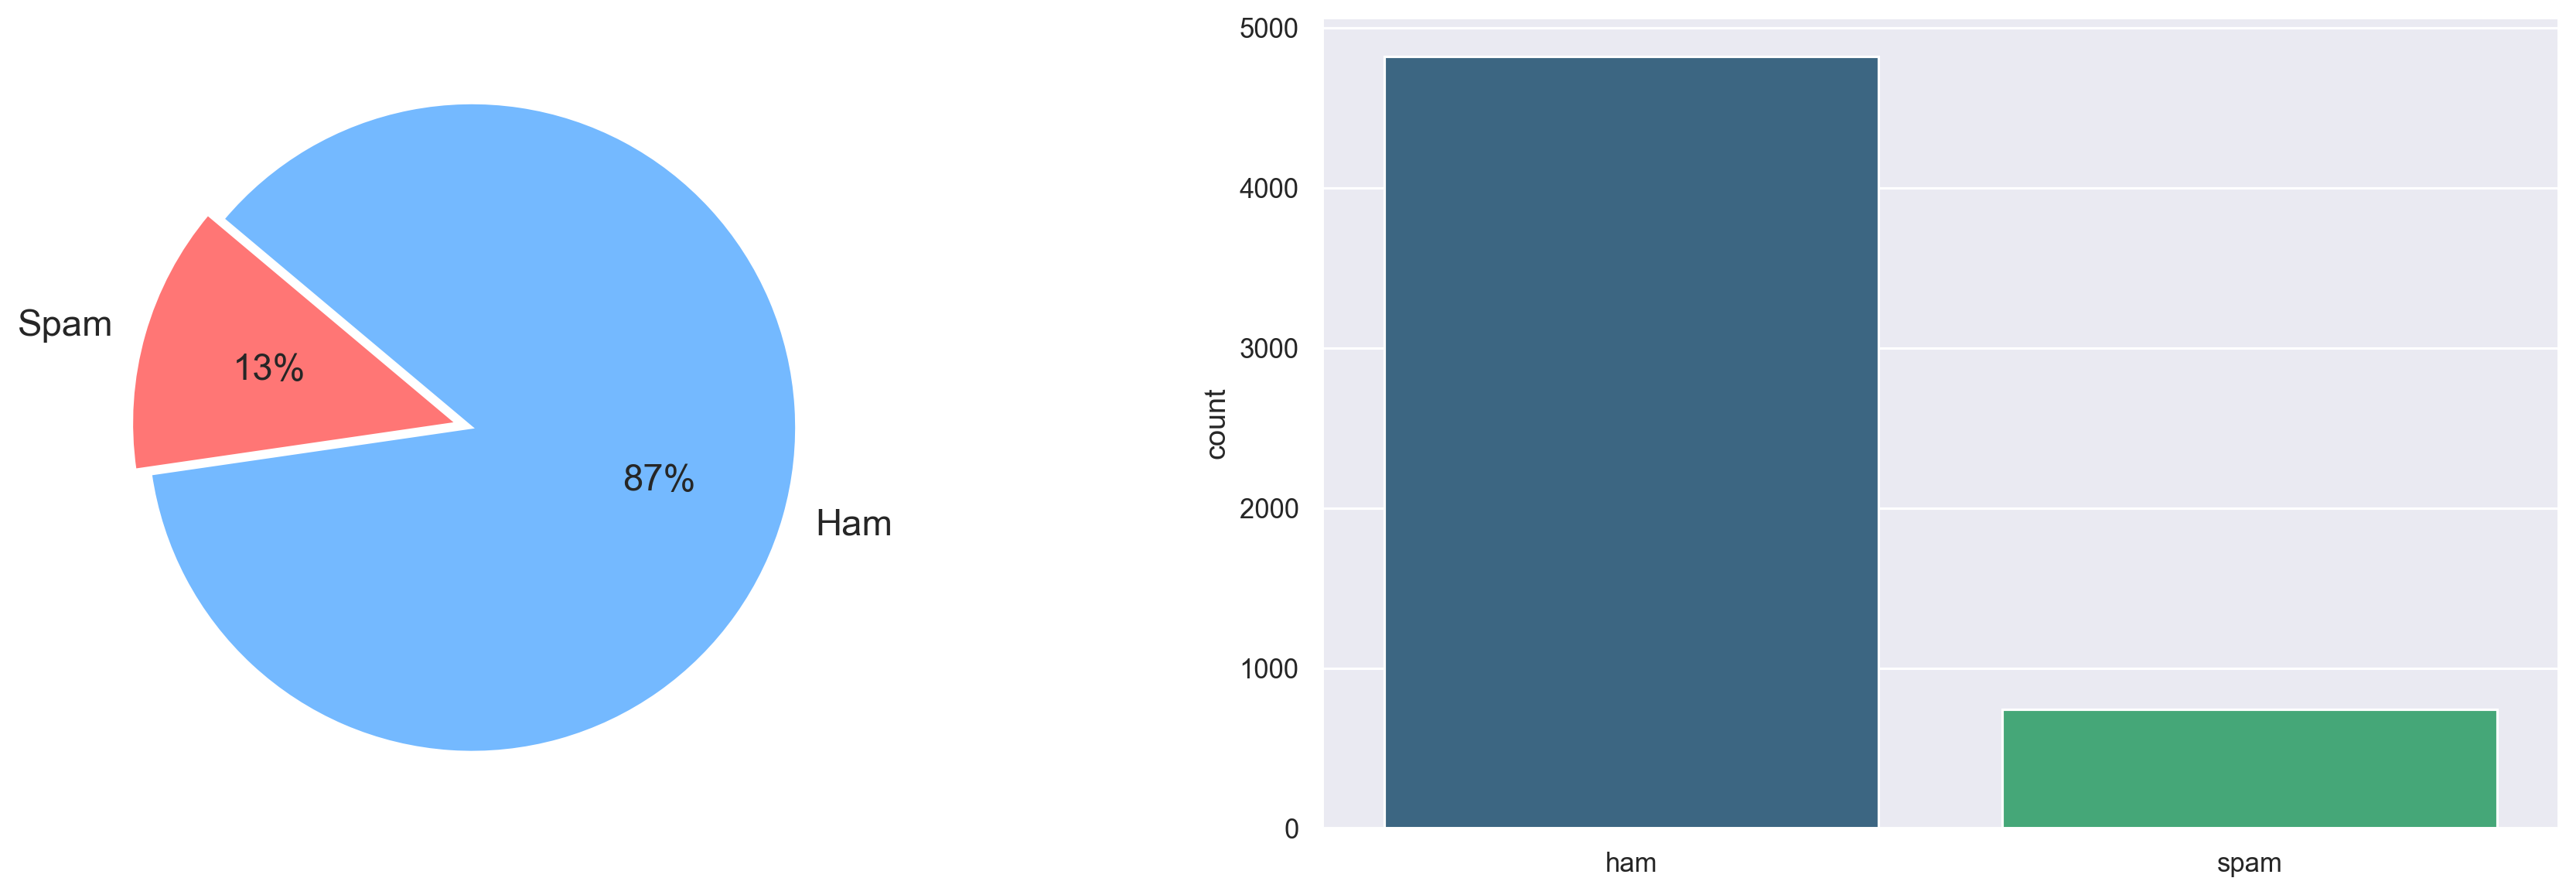

In [9]:
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')

plt.show()

#### **Feature Engineering** 
*   Creating new features e.g. total_words, total_chars.

In [10]:
data['Total Words'] = data['Message'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["Message"].apply(count_total_words)

In [11]:
data.head()

,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


We have created 2 new features in our dataset, lets try to see how our target variable changes based on these features

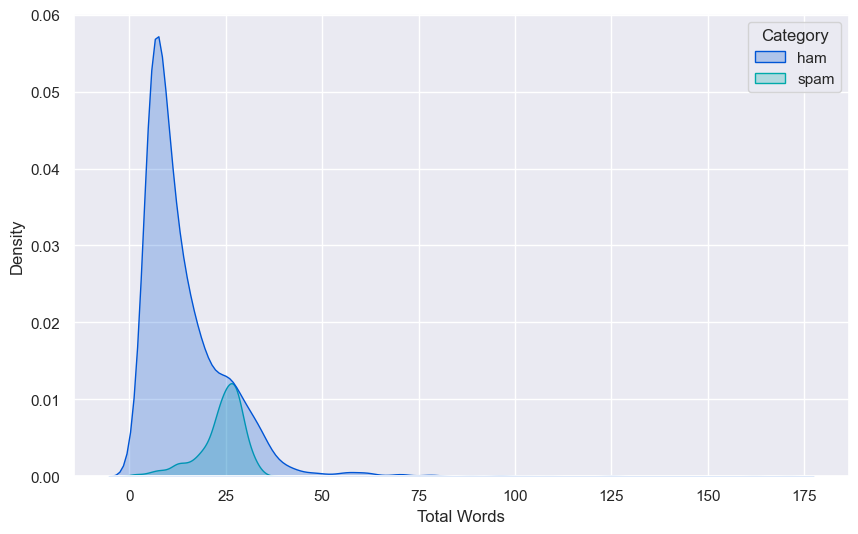

In [12]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

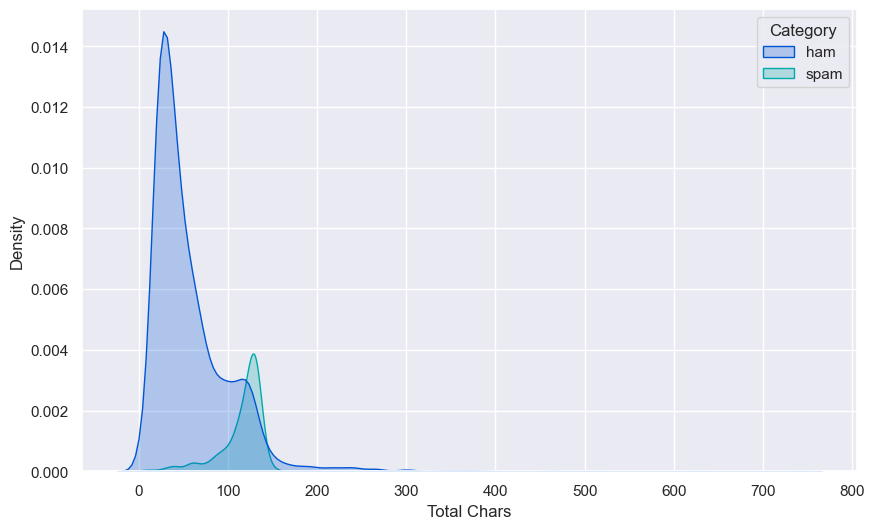

In [13]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

Clearly, one thing we can conclude here is that more the number of words in a text, there are more chances of it being spam

#### **Text Preprocessing**


In [14]:
data.head()

,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


#### **Lowercasing**

In [15]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

#### **Removing URLs**

In [16]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['Message'] = data['Message'].apply(remove_url)

#### **Removing Punctuations**

In [17]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['Message'] = data['Message'].apply(remove_punc)

#### **Removing stopwords**

In [20]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['Message'] = data['Message'].apply(remove_stopwords)

#### **Stemming**

In [21]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['Message'] = data['Message'].apply(perform_stemming)

In [22]:
data['Total Words After Transformation'] = data['Message'].apply(lambda x: np.log(len(x.split())))

In [23]:
data.head()

,Category,Message,Total Words,Total Chars,Total Words After Transformation
0,ham,go jurong point crazi avail bugi n great world...,20,92,2.772589
1,ham,ok lar joke wif u oni,6,24,1.791759
2,spam,free entri 2 wkli comp win fa cup final tkt 21...,28,128,3.135494
3,ham,u dun say earli hor u c alreadi say,11,39,2.197225
4,ham,nah dont think goe usf live around though,13,49,2.079442



#### **Data Visualization**

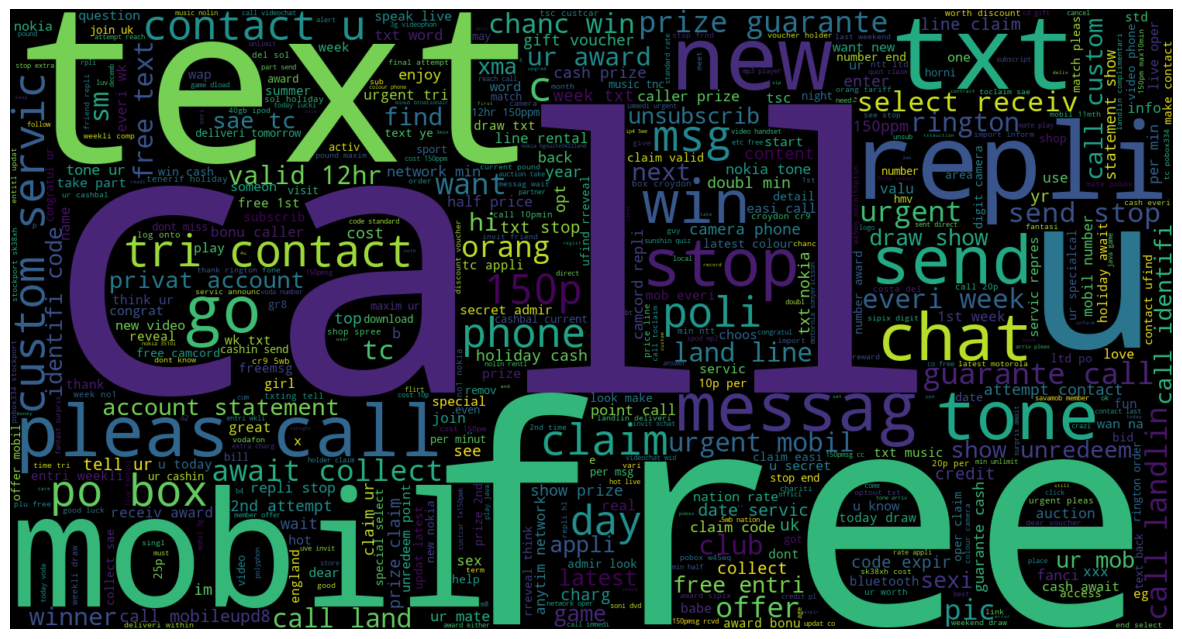

In [24]:
text = " ".join(data[data['Category'] == 'spam']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

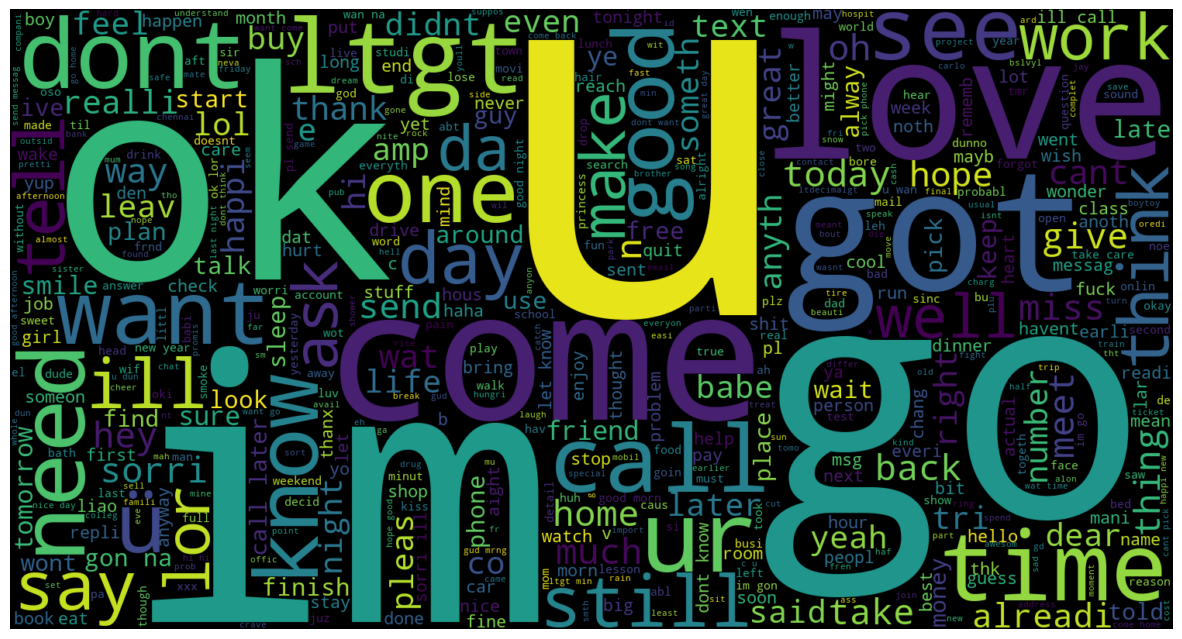

In [25]:
text = " ".join(data[data['Category'] == 'ham']['Message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [26]:
data['Category'] = data['Category'].replace({'spam':0,'ham':1})

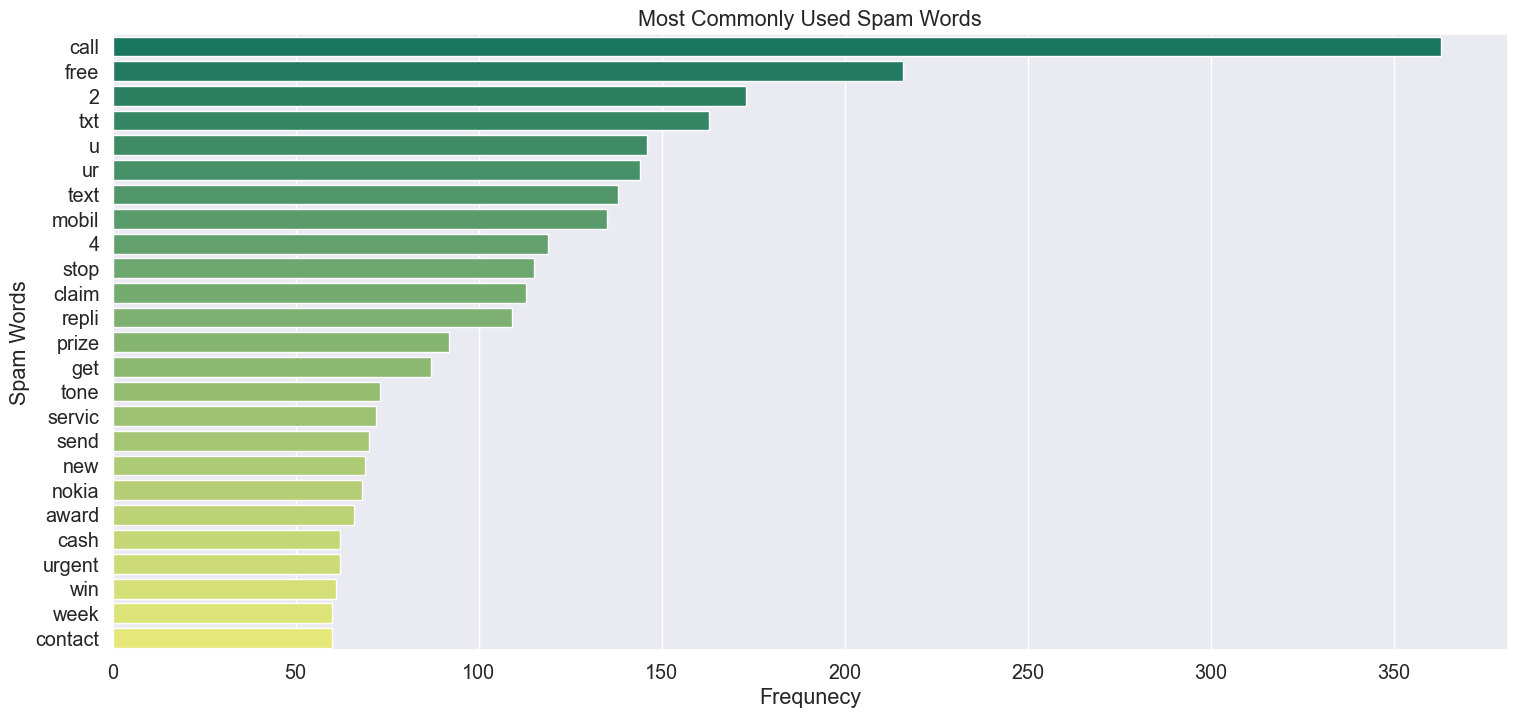

In [27]:
all_spam_words = []
for sentence in data[data['Category'] == 0]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

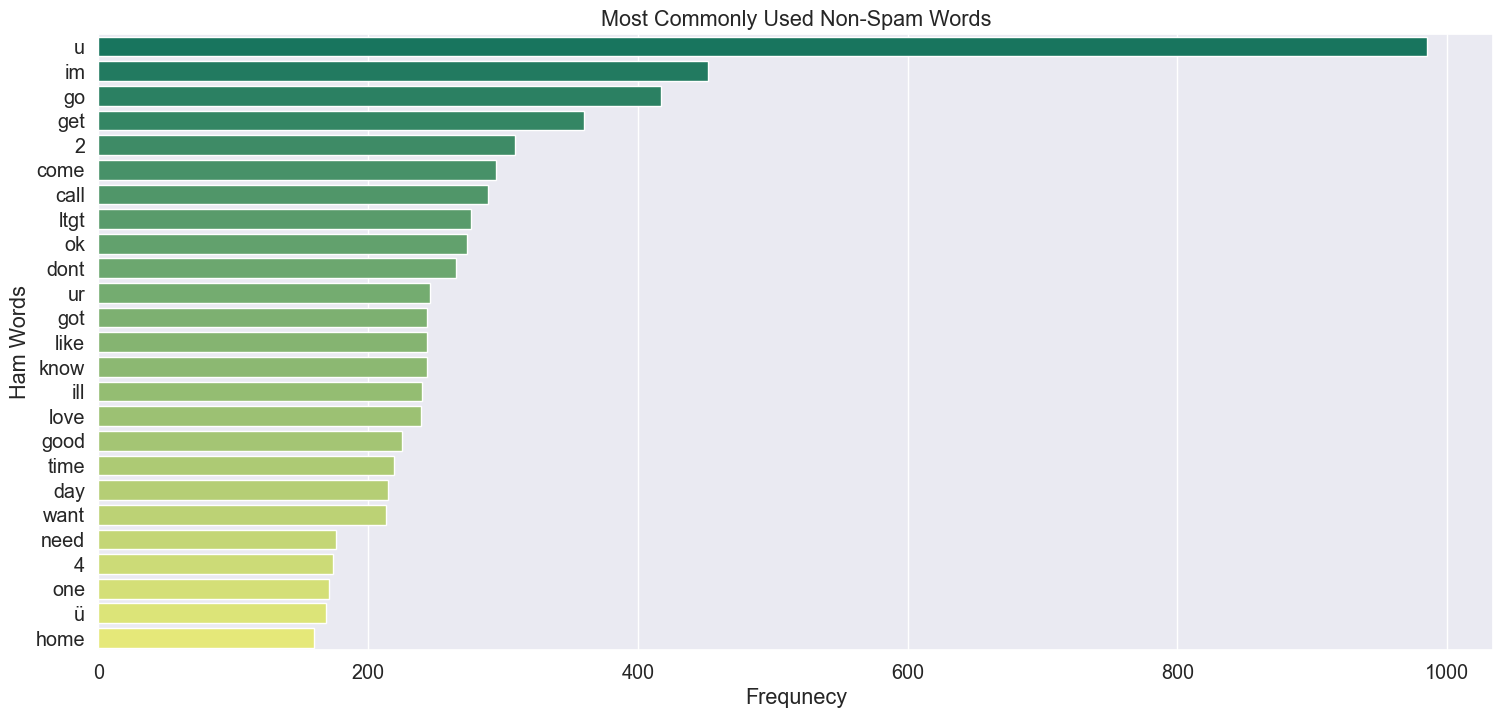

In [28]:
all_ham_words = []
for sentence in data[data['Category'] == 1]['Message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)

df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Non-Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()


#### **Text Vectorization**

In [29]:
X = data["Message"]
y = data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [30]:
y

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [31]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

#### **Random Forest**

In [29]:
# rf = RandomForestClassifier(n_estimators= 300)
# train_model(rf)

In [33]:
model_rf = RandomForestClassifier(n_estimators=300)

In [34]:
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)

accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)

print(f'Accuracy of the model: {accuracy}')
print(f'Precision Score of the model: {precision}')
print(f'Recall Score of the model: {recall}')

Accuracy of the model: 0.975
Precision Score of the model: 0.972
Recall Score of the model: 1.0


#### Random Forest has an accuracy of almost 0.98 and a recall score of 1. It also performed better than the naive bayes classifier.

In [35]:
import joblib

# joblib.dump(model_rf, 'spam_classification.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [41]:
text = "Reduce your debt by 50%! Get a free consultation today. Reply YES to find out more."
message = preprocess_text(text)
sample = tfidf.transform([message]).toarray()

In [42]:
pred = model_rf.predict(sample)
pred

array([1], dtype=int64)

In [40]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    re_url = re.compile(r'https?://\S+|www\.\S+')
    text = re_url.sub('', text)
    
    # Remove punctuation
    exclude = set(string.punctuation)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stopwords
    stopwrds = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwrds]
    
    # Perform stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

Series([], Name: Message, dtype: object)